### Agentic RAG
🤖 What is Agentic RAG?

Agentic RAG stands for Agentic Retrieval-Augmented Generation — an advanced version of RAG where instead of a static, one-shot LLM response,the system uses an agent that:

- reasons,
- plans,
- retrieves,
- uses tools,
- and even retries or reflects
to generate better, more grounded answers.

In [1]:
import os
from typing import List, Dict, Any, Optional, Annotated
from pydantic import BaseModel, Field


from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.chat_models import init_chat_model
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.schema import Document
from langgraph.graph import StateGraph, START, END



USER_AGENT environment variable not set, consider setting it to identify your requests.


In [4]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
llm = init_chat_model("openai:gpt-5-nano")

In [5]:
llm.invoke("Hello, how are you?")

AIMessage(content="Hi there! I'm here and ready to help with whatever you need. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 222, 'prompt_tokens': 12, 'total_tokens': 234, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 192, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CLwDr06NqEUdnIivOnzBw5nnVOHla', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--c3522141-c381-494e-bac2-a780f45dc846-0', usage_metadata={'input_tokens': 12, 'output_tokens': 222, 'total_tokens': 234, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 192}})

In [6]:
# -----------------------------
# 1. Document Preprocessing
# -----------------------------
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/"
]

loaders = [WebBaseLoader(url) for url in urls]
docs = []
for loader in loaders:
    docs.extend(loader.load())

docs


[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [7]:
## RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=50,
)

split_docs = text_splitter.split_documents(docs)


In [8]:
## Embeddings
embeddings = OpenAIEmbeddings()


## Vector Store
vectorstore = FAISS.from_documents(split_docs, embeddings)


## Retrieval
retriever = vectorstore.as_retriever()

In [9]:
retriever.invoke("What is Agentic RAG?")

[Document(id='3132f818-c6c5-4734-bf93-6c83777b65b2', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, 

In [18]:
### Define the RAG State

class RAGState(BaseModel):
    question: str
    retrieved_docs: List[Document] = []
    answer: str = ""

In [23]:
### 3. Langgraph Nodes


def retrieve_docs(state: RAGState) -> RAGState:
    docs = retriever.invoke(state.question)
    return RAGState(question=state.question, retrieved_docs=docs)



def generate_answer(state: RAGState) -> RAGState:

    context = "\n\n".join([doc.page_content for doc in state.retrieved_docs])
    prompt = f"Answer the following question based on the context provided:\n\nQuestion: {state.question}\n\nContext: {context}"
    answer = llm.invoke(prompt)
    return RAGState(question=state.question, retrieved_docs=state.retrieved_docs, answer=answer.content)

In [24]:
### 4. Langgraph Graph

builder = StateGraph(RAGState)

builder.add_node("retrieve", retrieve_docs)
builder.add_node("generate", generate_answer)

builder.add_edge(START, "retrieve")
builder.add_edge("retrieve", "generate")
builder.add_edge("generate", END)

graph = builder.compile()


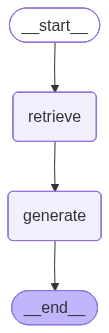

In [25]:
graph

In [26]:
# -----------------------------
# 5. Run the Agentic RAG
# -----------------------------

if __name__ == "__main__":
    user_question = "What is the concept of agent loop in autonomous agents?"
    initial_state = RAGState(question=user_question)
    final_state = graph.invoke(initial_state)

    print("\n✅ Final Answer:\n", final_state['answer'])


✅ Final Answer:
 An agent loop is the ongoing, cyclical process by which an autonomous agent operates: it senses or recalls information from the environment, reasons and plans a course of action, executes actions (often via tools or APIs), observes the outcomes, and then updates its internal state and plans for the next cycle. This loop enables learning from past experiences and adapting behavior over time.

Key aspects from the context:
- Memory, planning, and self-reflection are integrated so decisions can be conditioned on past experiences.
- Self-reflection helps refine past actions and correct mistakes, supporting iterative improvement.
- Agents can interact with other agents and use tools (web browsing, code execution, robotics APIs, etc.) within each loop.
- Complex tasks can be handled with explicit reasoning steps (e.g., chain-of-thought or tree-of-thought approaches) during the planning and reflection phases.

Typical steps in an agent loop:
- Perceive/Recall: gather current

In [27]:
final_state

{'question': 'What is the concept of agent loop in autonomous agents?',
 'retrieved_docs': [Document(id='736eb114-fcfb-4e8b-ab7c-210fd45e4eb6', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism an